In [6]:
import pandas as pd

df_embeds = pd.read_pickle('data/username_weighted_embeds.pkl')
df_train_all = pd.read_pickle('data/training-dataset.pkl')

df_embeds

,username,embeds_wavg
0,01burdaavm,"[-0.1506200568919832, 0.03222121708690379, 0.0..."
1,1001sanat,"[-0.10759458329309435, 0.017608935367624166, 0..."
2,1924istanbul,"[-0.14113727936690507, 0.022148012823097155, 0..."
3,1983beyoglu,"[-0.12147194619689669, 0.02344309704378247, 0...."
4,1dil1insan,"[-0.1526504227093288, 0.012321048611775041, -0..."
...,...,...
3469,zpor,"[-0.1559152962054525, -0.0007559643719910777, ..."
3470,zuhaldentakilar,"[-0.16174798037324634, 0.007258129771133618, -..."
3471,zulaoyun,"[-0.15004816178232433, 0.01378580880118534, 0...."
3472,zulaoyunespor,"[-0.13027670212090015, 0.02870892519131303, 0...."


In [7]:
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.model_selection import train_test_split

df_train = pd.merge(df_embeds, df_train_all[['username','category_enum','label']], how='left', on='username')
df_train = df_train.dropna(subset=['label'])
df_train = df_train.drop(columns=['username'])
df_train['category_enum'] = df_train['category_enum'].fillna('Missing')



labels = ['entertainment', 'food', 'travel', 'health and lifestyle', 'mom and children', 'fashion', 'tech', 'sports', 'art', 'gaming']

label_encoder = LabelEncoder()
label_encoder.fit(labels)

df_train['target'] = label_encoder.transform(df_train['label'])
df_train = df_train.drop(columns=['label'])


X = df_train.drop(columns=['target'])
y = df_train[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


encoder = TargetEncoder()
cat_encoded_train = encoder.fit_transform(X_train["category_enum"].to_numpy().reshape(-1,1), y_train['target'].tolist())
X_train['category_encoded'] = [row.tolist() for row in cat_encoded_train]
X_train = X_train[['embeds_wavg','category_encoded']]

X_train = pd.concat([pd.DataFrame(X_train['category_encoded'].tolist()), pd.DataFrame(X_train['embeds_wavg'].tolist())],axis=1)



cat_encoded_test = encoder.transform(X_test['category_enum'].to_numpy().reshape(-1,1))
X_test['category_encoded'] = [row.tolist() for row in cat_encoded_test]
X_test = pd.concat([pd.DataFrame(X_test['category_encoded'].tolist()), pd.DataFrame(X_test['embeds_wavg'].tolist())],axis=1)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import numpy as np


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(10, activation='softmax')
])


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

Epoch 1/100


/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1736480888.855907  533787 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1736480889.063444  533787 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major ve

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/usr/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/usr/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_533637/1229589506.py", line 48, in <module>

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_9669]


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.31      0.38        36
           1       0.51      0.46      0.48        70
           2       0.67      0.68      0.67        65
           3       0.79      0.83      0.81       101
           4       0.00      0.00      0.00         3
           5       0.59      0.74      0.65       102
           6       0.38      0.19      0.26        26
           7       0.87      0.71      0.78        28
           8       0.64      0.84      0.73        63
           9       0.72      0.57      0.64        54

    accuracy                           0.65       548
   macro avg       0.57      0.53      0.54       548
weighted avg       0.64      0.65      0.64       548


Additional Metrics:
Accuracy: 0.6478
Macro F1: 0.5398
Weighted F1: 0.6350
Macro Precision: 0.5659
Macro Recall: 0.5329


/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: 

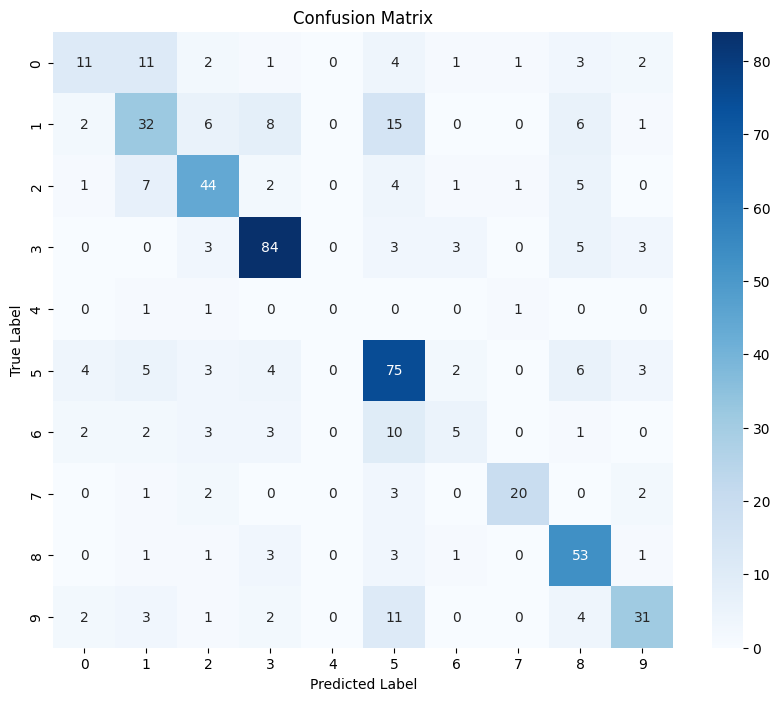

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Print detailed metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

